In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import math
import json

import istarmap  # import to apply monkey patch to multiprocess
import multiprocess
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats 
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import StandardScaler, RobustScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

from aggregators import bucket_and_bin

In [3]:
# ouputs
fn_distance = '../data/output/figs/fig2_dist.csv'
fn_disparity = '../data/output/tables/table1_cities_ranked_by_categories.csv'
fn_regression_all = '../data/output/tables/table2_regression_outputs_all.csv'
fn_regression_income = '../data/output/tables/table3a_regression_outputs_income.csv'
fn_regression_race = '../data/output/tables/table3b_regression_outputs_race.csv'
fn_regression_redlining = '../data/output/tables/table3c_regression_outputs_redlining.csv'


fn_observed_income = '../data/output/figs/fig4_income.csv'
fn_adjusted_income = '../data/output/figs/fig5_income.csv'
fn_observed_race = '../data/output/figs/fig4_race.csv'
fn_adjusted_race= '../data/output/figs/fig5_race.csv'
fn_observed_redlining = '../data/output/figs/fig4_redlining.csv'
fn_adjusted_redlining = '../data/output/figs/fig5_redlining.csv'

# inputs
fn_att = '../data/output/speed_price_att.csv.gz'
fn_centurylink = '../data/output/speed_price_centurylink.csv.gz'
fn_verizon = '../data/output/speed_price_verizon.csv.gz'
fn_earthlink = '../data/output/speed_price_earthlink.csv.gz'
inputs = {
    "AT&T" : fn_att,
    "CenturyLink": fn_centurylink,
    "Verizon": fn_verizon,
    "EarthLink" : fn_earthlink
}

# params
recalculate = False
n_jobs = 10

In [4]:
# for isp, fn in inputs.items():
#     _df = filter_df(fn, isp)
#     for city, __df in _df.groupby('major_city'):
#         print(city, isp, len(__df))
#         print(aspirational_quartile(__df['median_household_income'], 
#                                     labels=income_labels).value_counts(dropna=False, normalize=True))

In [5]:
def filter_df(fn, isp):
    """
    Filters out no service offers, and cities which we can't analyze
    """
    df = pd.read_csv(fn)
    df = df[df.speed_down != 0]
    df = bucket_and_bin(df)
    df['isp'] = isp
    if isp == 'Verizon':
        df.price = df.price.replace({40: 39.99, 49.99: 39.99})
        df = df[df.price == 39.99]
        nyc_cities = ['new york', 'brooklyn', 'queens', 'staten island', 'brooklyn', 'bronx']
        nyc = []
        for city, _df in df.groupby('major_city'):
            if city in nyc_cities:
                nyc.extend(_df.to_dict(orient='records'))
        nyc = pd.DataFrame(nyc)
        nyc['major_city'] = 'new york city'
        
        # add NYC
        df = df[~df.major_city.isin(nyc_cities)]
        df = df.append(nyc)
        
    elif isp == 'EarthLink':
        df = df[df.contract_provider.isin(['AT&T', 'CenturyLink'])]
    # filter out cities that don't have variety of speeds
#     variety = df.groupby(['major_city', 'state']).speed_down_bins.value_counts(normalize=True)
#     homogenous_cities = set(variety[variety >= .95].index.get_level_values(0))
    homogenous_cities = set()
    homogenous_cities.add('bridgeport') # just four offers from non-frontier
    homogenous_cities.add('wilmington')
    df = df[~df.major_city.isin(homogenous_cities)]
    return df

In [6]:
c = 0
cities = set()
for (isp, fn) in inputs.items():
    d = filter_df(fn, isp=isp)
    cities.update(d.major_city.unique())
    c += len(d)
    print(f"{isp} we analyzed {len(d)} addresses from {d.major_city.nunique()} cities")
c, len(cities)

AT&T we analyzed 343591 addresses from 20 cities


<ipython-input-6-9af7006426e1>:4: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  d = filter_df(fn, isp=isp)


CenturyLink we analyzed 180067 addresses from 15 cities


<ipython-input-6-9af7006426e1>:4: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  d = filter_df(fn, isp=isp)


Verizon we analyzed 223259 addresses from 8 cities
EarthLink we analyzed 390693 addresses from 33 cities


(1137610, 43)

In [7]:
# data = []
# for (isp, fn) in inputs.items():
#     d = filter_df(fn, isp=isp)
#     for city, _df in tqdm(d.groupby('major_city'), total=d.major_city.nunique()):
#         _df = bucket_and_bin(_df)
#         data.extend(_df.to_dict(orient='records'))

In [8]:
# df = pd.DataFrame(data)

## Median Distance

In [9]:
isp2house = {
    'Verizon': '../data/output/figs/house_emoji_brick.png',
    'AT&T': '../data/output/figs/house_emoji.png',
    'CenturyLink': '../data/output/figs/house_emoji_blue.png'
}

In [10]:
cols = [
    'address_full',
    'lat', 'lon',
    'race_perc_non_white',
    'n_providers',
    'median_household_income',
    'redlining_grade'
]
def plot_distance_to_fiber(slow_to_blazin, isp):
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=label, markerfacecolor="#1f66e0", markersize=10)
                   for label, c in isp2house.items()][::-1]
    slow_to_blazin.major_city = slow_to_blazin.major_city.apply(lambda x: x.title())
    to_plot = slow_to_blazin.groupby(['major_city', 'state', 'isp']).closest_fiber_miles.median().sort_values(ascending=True)
    to_plot = (to_plot * 1609.34).reset_index()
    to_plot['zeros'] = 0
    print(to_plot.head(3))
    title = f"Median Distance Between Households {isp}\nOffered Slow Speeds and Blazin' Fiber Speeds"
    ax = to_plot.plot(x = 'closest_fiber_miles', y='major_city', kind='scatter',
                 s= 90, color ='#4385f2', figsize=(6, 10),
                 title=title)
    to_plot.plot(x = 'closest_fiber_miles', y='major_city', kind='scatter',
                 s= 20, color ='white', ax=ax)
    for i, (_, row) in enumerate(to_plot.iterrows()):
        x = row['closest_fiber_miles']
        fn_image = isp2house.get(row['isp'])
        image = OffsetImage(plt.imread(fn_image), zoom=.035)
        ab = AnnotationBbox(image, (x, i), frameon=False)
        ax.add_artist(ab)
    
    x1 = np.zeros(len(to_plot)).tolist()
    x2 = to_plot['closest_fiber_miles'].tolist()
    n = to_plot['major_city'].tolist()
    for i in range(0, len(x1)):
        plt.plot([x1[i], x2[i]], [n[i], n[i]], '-', color='#4385f2', lw=4, zorder=-1)

    # Hide the right and top spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')

    ax.set_xlim(left=0)
    labels = ax.get_xticks().tolist()
    labels = [int(_) for _ in labels]
    labels[0] = "0 meters"
    ax.set_xticklabels(labels)
    
    plt.gca().invert_yaxis()

    ax.set_xlabel("")
    ax.set_ylabel("")
#     ax.get_legend().remove()
    
    ax.grid(axis='x', zorder=0)
    ax.set_ylim(top=n[0], bottom=n[-1])
    plt.show()

In [11]:
slows_to_blazins = pd.DataFrame([])
for isp, fn in inputs.items():
    if isp == 'EarthLink': continue
    df = filter_df(fn, isp)
    for city, _df in df.groupby(['major_city']):
        n_slow = len(_df[_df.speed_down_bins == 'Slow (<25 Mbps)'])
        n_not_slow = len(_df[_df.speed_down_bins != 'Slow (<25 Mbps)'])
        n_all = len(_df)
        if (_df.speed_down_bins.nunique() <= 1) or (n_slow / n_all <= .01) or (n_not_slow / n_all <= .01):
            continue
        slow_to_blazin = _df[(_df.closest_fiber_miles != 0) & 
                            (_df.speed_down <= 25)]
        slows_to_blazins = slows_to_blazins.append(slow_to_blazin)

<ipython-input-11-d3891d53ddcc>:4: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  df = filter_df(fn, isp)
<ipython-input-11-d3891d53ddcc>:4: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  df = filter_df(fn, isp)


     major_city state      isp  closest_fiber_miles  zeros
0  Philadelphia    PA  Verizon            35.585935      0
1        Boston    MA  Verizon            53.643582      0
2    Washington    DC  Verizon            75.804138      0


<ipython-input-10-3194b9122f6e>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


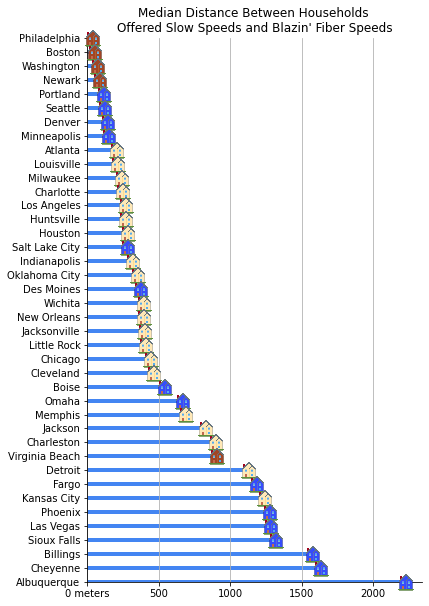

In [12]:
plot_distance_to_fiber(slows_to_blazins, isp="")

In [13]:
dist_summary = slows_to_blazins.groupby(['major_city', 'state', 'isp']).closest_fiber_miles.median().sort_values(ascending=True)

In [14]:
dist_summary.to_csv(fn_distance)

In [15]:
slows_to_blazins.groupby('isp').closest_fiber_miles.median().sort_values(ascending=True)* 1609.34

isp
Verizon        123.605197
AT&T           415.118421
CenturyLink    659.793897
Name: closest_fiber_miles, dtype: float64

In [16]:
dist_summary * 1609.34

major_city      state  isp        
Philadelphia    PA     Verizon          35.585935
Boston          MA     Verizon          53.643582
Washington      DC     Verizon          75.804138
Newark          NJ     Verizon          87.506333
Portland        OR     CenturyLink     117.594082
Seattle         WA     CenturyLink     121.755967
Denver          CO     CenturyLink     146.930425
Minneapolis     MN     CenturyLink     148.974406
Atlanta         GA     AT&T            206.139991
Louisville      KY     AT&T            217.147994
Milwaukee       WI     AT&T            239.148902
Charlotte       NC     AT&T            246.165900
Los Angeles     CA     AT&T            269.980644
Huntsville      AL     AT&T            270.237510
Houston         TX     AT&T            281.306554
Salt Lake City  UT     CenturyLink     283.378684
Indianapolis    IN     AT&T            319.762967
Oklahoma City   OK     AT&T            356.592321
Des Moines      IA     CenturyLink     371.318707
Wichita        

In [17]:
def which_has_largest_proportion(df, col='income_level', bins=['Low'], comparison=[], limit=300):
    sample1 = df[df[col].isin(bins)]
    if len(comparison) != 0:
        sample2 = df[df[col].isin(comparison)]
    else:
        sample2 = df[~df[col].isin(bins)]
        
    if len(sample1) < limit or len(sample2) < limit:
        return None, None, None, 'small bin'
    
    try:
        prop1 = len(sample1[sample1.is_slow == 1]) / len(sample1)
        prop2 = len(sample2[sample2.is_slow == 1]) / len(sample2)
        return prop1, prop2, round(prop1 - prop2, 3) >= .05, None
    except Exception as e:
        print(e, df.head(2))
        return None, None, None, e

def test_flow(df, isp, params):
    iv = params['iv']
    data = []
    
    s = df.groupby('major_city').race_perc_non_white.quantile([.25,.75]).unstack()
    s['delta'] = s[0.75] - s[0.25]
    race_cities = set(s[s.delta >= .2].index)
    
    for (city, state), _df in df.groupby(['major_city', 'state']):
        _df = bucket_and_bin(_df)
        n_slow = len(_df[_df.is_slow == True])
        n_not_slow = len(_df[_df.is_slow == False])
        n_all = len(_df)
        
        variety = _df.speed_down_bins.value_counts(normalize=True)
        variety[variety >= .95]
        
        if len(variety[variety >= .95]) != 0:
            # skip cities with homogenous speed (this is just for EarthLink and Verizon)
            data.append({'major_city': city, 'state': state, 'isp': isp,
                         f'prop_slow_{iv}_exposure': None,
                         f'prop_slow_{iv}_treatment': None,
                         f'prop_slow_{iv}_delta' : None,
                         'flag': 'monospeed'})
            continue
        if iv == 'income':
            a, b, is_larger, flag = which_has_largest_proportion(_df, col=params['col'], bins=params['grades'],
                                                                comparison=params['comparison'])

        elif iv == 'redlining':
            _df_rated = _df[~_df.redlining_grade.isnull()]
            if len(_df_rated) / n_all <= .05:
                data.append({'major_city': city, 'state': state, 'isp': isp,
                         f'prop_slow_{iv}_exposure': None,
                         f'prop_slow_{iv}_treatment': None,
                         f'prop_slow_{iv}_delta' : None,
                           'flag': 'not HOLC graded'})
                continue
            a, b, is_larger, flag = which_has_largest_proportion(_df, col=params['col'], bins=params['grades'],
                                                           comparison=params['comparison'])
        elif iv == 'race':
            n_minority_white = len(_df[_df.race_perc_non_white > .50])
            n_majority_white = len(_df[_df.race_perc_non_white < .50])
            # check only cities with at least 5 percent of addresses in minority white.
            if (n_minority_white / n_all <= .05) or (n_majority_white / n_all <=.05):
#             if city not in race_cities:
                data.append({'major_city': city, 'state': state, 'isp': isp,
                         f'prop_slow_{iv}_exposure': None,
                         f'prop_slow_{iv}_treatment': None,
                         f'prop_slow_{iv}_delta' : None,
                          'flag' : 'no diversity'})
                continue
            a, b, is_larger, flag = which_has_largest_proportion(_df, col=params['col'], bins=params['grades'],
                                                          comparison=params['comparison'])

        data.append({
            'major_city': city,
            'state': state,
            f'slowest_{iv}' : is_larger,
            'isp': isp,
            f'prop_slow_{iv}_exposure': a,
            f'prop_slow_{iv}_treatment': b,
            f'prop_slow_{iv}_delta' : a-b if a else None,
            'flag': flag
        })
        
    return data

In [18]:
income_params = {'iv': "income", 'grades': ['Low'], 'col': 'income_level'}
race_params = {'iv': "race", 'grades': ['least white'], 'col': 'race_quantile'}
redlining_params = {'iv': "redlining", 'grades': ['D'], 'col': 'redlining_grade'}

# Treatment group
income_params['comparison'] = ['Upper Income']
race_params['comparison'] = ['most white']
redlining_params['comparison'] = ['A', 'B']

In [19]:
if not os.path.exists(fn_disparity) or recalculate:
    table = pd.DataFrame()
    for isp, fn in tqdm(inputs.items()):
        df = filter_df(fn, isp)
        income_data = test_flow(df, isp=isp, params=income_params)
        race_data = test_flow(df, isp=isp, params=race_params)
        redlining_data = test_flow(df, isp=isp, params=redlining_params)

        df_table = pd.DataFrame(income_data).merge(
            pd.DataFrame(race_data), on=['major_city', 'isp', 'state'], how='outer'
        ).merge(
            pd.DataFrame(redlining_data), on=['major_city', 'isp', 'state'], how='outer'
        )

        table = table.append(df_table)
    table.major_city = table.major_city.str.title()
    table.to_csv(fn_disparity, index=False)

else:
    table = pd.read_csv(fn_disparity)

In [20]:
# all cities in the study
n_cities = table.major_city.nunique()
n_cities
trend = set(table[(table.slowest_income == True) | 
      (table.slowest_race == True) | 
      (table.slowest_redlining == True)].major_city.unique())

reverse_trend = set(table[(table.slowest_income == False) & 
      (table.slowest_race == False) & 
      (table.slowest_redlining == False)].major_city.unique())

In [21]:
# how many cities exhibit none of these trends?
set(table.major_city.unique()) - trend

{'Baltimore',
 'Boise',
 'Boston',
 'Fargo',
 'New York City',
 'Philadelphia',
 'Providence'}

In [22]:
table[table.major_city == 'Washington']

,major_city,state,slowest_income,isp,prop_slow_income_exposure,prop_slow_income_treatment,prop_slow_income_delta,flag_x,slowest_race,prop_slow_race_exposure,prop_slow_race_treatment,prop_slow_race_delta,flag_y,slowest_redlining,prop_slow_redlining_exposure,prop_slow_redlining_treatment,prop_slow_redlining_delta,flag
42,Washington,DC,True,Verizon,0.317305,0.125173,0.192132,NaN,False,0.279925,0.283562,-0.003638,NaN,NaN,NaN,NaN,NaN,not HOLC graded


In [23]:
random.seed(303)
summary_data = []
for isp in inputs.keys():
    table_ = table[table.isp == isp]
    display(Markdown(f"{isp} was significantly more likely to offer slow speeds in..."))
    
    if isp == 'EarthLink':
        table_['major_city'] = table_.apply(lambda x: f"{x['major_city']} ({x['state'].upper()})", axis=1)
        
    null_cities = table_[(table_.slowest_income.isnull()) | (table_.prop_slow_income_treatment == 0)].major_city.unique()
    all_cities = table_.major_city.nunique()
    all_cities -= len(null_cities)
    
    # income
    n_cities = table_[~table_.slowest_income.isnull()].major_city.nunique()
    cities = table_[table_.slowest_income == True].major_city.unique()
    sig_opposite_cities = table_[table_.slowest_income == False].major_city.unique()
    
    random.shuffle(cities)
    n_low = len(cities)
    
    record_income ={
        'isp': isp,
        'null_cities' : null_cities.tolist(),
        'all_cities' : all_cities,
        'income_cities' : table_[~table_.slowest_income.isnull()].major_city.nunique(),
        'income_percent_low_income': round(n_low / n_cities * 100, 1),
        'income_cities_significant': cities.tolist(),
        'income_cities_non_significant_anti_trend': sig_opposite_cities.tolist()
    }
    
    text =  (
        f"- {' and '.join(income_params['grades'])} Income areas than Upper Income areas in **{round(n_low / n_cities * 100, 1)}**% of cities ({n_low})."
#         f"<br>This includes cities like {cities[0].title()}, {cities[1].title()}, and {cities[2].title()}."
    )
    if len(sig_opposite_cities) > 0:
        perc = round(len(sig_opposite_cities) / n_cities * 100, 1)
        text += f"<br>The opposite trend was in {perc}% of cities ({len(sig_opposite_cities)})."

    display(Markdown(text))

    # race
    n_cities = table_[~table_.slowest_race.isnull()].major_city.nunique()
    random.shuffle(cities)
    cities = table_[table_.slowest_race == True].major_city.unique()
    
    sig_opposite_cities = table_[table_.slowest_race == False].major_city.unique()
    
    random.shuffle(cities)
    n_minority_white = len(cities)
    
    record_race ={
        'isp': isp,
        'race_cities' : table_[~table_.slowest_race.isnull()].major_city.unique().tolist(),
        'race_percent_low_income': round(n_minority_white / n_cities * 100, 1),
        'race_cities_non_significant_anti_trend': sig_opposite_cities.tolist()
    }
    
    text = (
        f"- the {' and '.join(race_params['grades'])} areas compared to the most white areas in <b>{round(n_minority_white / n_cities * 100, 1)}</b>% of cities ({n_minority_white})."
#         f"<br>This includes cities like {', '.join([c.title() for c in cities[:3]])}.\n"
    )
    if len(sig_opposite_cities) > 0:
        perc = round(len(sig_opposite_cities) / n_cities * 100, 1)
        text += f"<br>The opposite trend was in {perc}% of cities ({len(sig_opposite_cities)})."
 
    
    if n_cities < all_cities:
        diff = all_cities - n_cities
        record_race['race_n_cities_cant_analyze'] = diff
        text += f"<br>We exclude {diff} {'cities' if diff > 1 else 'city'} for not containing enough minority white areas for comparison."
    display(Markdown(text))

    # redlining
    n_cities = table_[~table_.slowest_redlining.isnull()].major_city.nunique()
    cities = table_[table_.slowest_redlining == True].major_city.unique()
    sig_opposite_cities = table_[table_.slowest_redlining == False].major_city.unique()
    random.shuffle(cities)
    n_redline = len(cities)
    
    record_redlining ={
        'isp': isp,
        'redline_cities' : table_[~table_.slowest_redlining.isnull()].major_city.unique().tolist(),
        'redline_percent_low_income': round(n_redline / n_cities * 100, 1),
        'redline_cities_non_significant_anti_trend': sig_opposite_cities.tolist()
    }
    summary_data.append({**record_income, **record_race, **record_redlining})
    
    if len(cities) >= 3:
        text = (
            f"- {' and '.join(redlining_params['grades'])}"
            f" graded areas than A and B graded areas in **{round(n_redline/ n_cities * 100, 1)}**% of cities ({n_redline})."
#             f"<br>This includes cities like {cities[0].title()}, {cities[1].title()}, and {cities[2].title()}."
        )
    else:
        text = (
            f"- {' and '.join(redlining_params['grades'])}"
            f" graded areas than better graded areas in **{round(n_redline/ n_cities * 100, 1)}**% of cities ({n_redline})."
#             f"<br>This includes cities like {cities[0].title()}."
        )
    if len(sig_opposite_cities) > 0:
        perc = round(len(sig_opposite_cities) / n_cities * 100, 1)
        text += f"<br>The opposite trend was statistically significant in {perc}% of cities ({len(sig_opposite_cities)})."
    
    if n_cities < all_cities:
        diff = all_cities - n_cities
        record_redlining['redline_n_cities_cant_analyze'] = diff
        text += f"<br>We exclude {diff} {'cities' if diff > 1 else 'city'} for not containing enough HOLC graded areas for comparison."
    display(Markdown(text))

    if len(null_cities) > 0:
        n_null = len(null_cities)
        if n_null == 1:
            text = f"Note: {null_cities[0].title()} was only offered slow speeds. We exclude this city from the above calculations."
        else:
            text =(
                f"Note: we exclude {n_null} {'cities' if n_null > 1 else 'city'} that are served the same speed."
                f" This includes {', '.join([c.title() for c in null_cities[:3]])}."
            )
        display(Markdown(text))
    
    display(Markdown('<hr>'))

AT&T was significantly more likely to offer slow speeds in...

- Low Income areas than Upper Income areas in **95.0**% of cities (19).<br>The opposite trend was in 5.0% of cities (1).

- the least white areas compared to the most white areas in <b>57.9</b>% of cities (11).<br>The opposite trend was in 42.1% of cities (8).<br>We exclude 1 city for not containing enough minority white areas for comparison.

- D graded areas than A and B graded areas in **100.0**% of cities (14).<br>We exclude 6 cities for not containing enough HOLC graded areas for comparison.

<hr>

CenturyLink was significantly more likely to offer slow speeds in...

- Low Income areas than Upper Income areas in **86.7**% of cities (13).<br>The opposite trend was in 13.3% of cities (2).

- the least white areas compared to the most white areas in <b>63.6</b>% of cities (7).<br>The opposite trend was in 36.4% of cities (4).<br>We exclude 4 cities for not containing enough minority white areas for comparison.

- D graded areas than A and B graded areas in **100.0**% of cities (7).<br>We exclude 8 cities for not containing enough HOLC graded areas for comparison.

<hr>

Verizon was significantly more likely to offer slow speeds in...

- Low Income areas than Upper Income areas in **100.0**% of cities (3).

- the least white areas compared to the most white areas in <b>50.0</b>% of cities (1).<br>The opposite trend was in 50.0% of cities (1).<br>We exclude 1 city for not containing enough minority white areas for comparison.

- D graded areas than better graded areas in **100.0**% of cities (1).<br>We exclude 2 cities for not containing enough HOLC graded areas for comparison.

Note: we exclude 5 cities that are served the same speed. This includes Baltimore, Boston, New York City.

<hr>

EarthLink was significantly more likely to offer slow speeds in...

- Low Income areas than Upper Income areas in **73.7**% of cities (14).<br>The opposite trend was in 26.3% of cities (5).

- the least white areas compared to the most white areas in <b>50.0</b>% of cities (9).<br>The opposite trend was in 50.0% of cities (9).<br>We exclude 1 city for not containing enough minority white areas for comparison.

- D graded areas than A and B graded areas in **100.0**% of cities (13).<br>We exclude 6 cities for not containing enough HOLC graded areas for comparison.

Note: we exclude 14 cities that are served the same speed. This includes Albuquerque (Nm), Billings (Mt), Boise (Id).

<hr>

### What patterns emerge when we collapose the ISPs together, and look at cities?

In [24]:
table.major_city.nunique()

43

In [25]:
income_cities = table[~table.slowest_income.isnull()].major_city.unique()
race_cities = table[~table.slowest_race.isnull()].major_city.unique()
redlining_cities = table[~table.slowest_redlining.isnull()].major_city.unique()

In [26]:
all_cities = table[~table.slowest_income.isnull()].major_city.nunique()

In [27]:
# table_old = table.copy()

In [28]:
for params in [income_params, race_params ,redlining_params]:
    iv = params['iv']
    base_group = params['grades'][0]
    
    # filter out cases we omitted for lack of data
    null = table[table[f'slowest_{iv}'].isnull()]
    null_city =  (set(table[table[f'slowest_{iv}'].isnull()].major_city.unique()) -
                     set(table[~table[f'slowest_{iv}'].isnull()].major_city))
    all_sig = table[~table[f'slowest_{iv}'].isnull()]
    all_cities_tested = all_sig.major_city.nunique()
#     homogenous = table[(table[f'prop_slow_{iv}_exposure'] == 0) | (table[f'prop_slow_{iv}_treatment'] == 0)]
    
    table_ = table[(table[f'prop_slow_{iv}_exposure'] != 0) & 
                   (table[f'prop_slow_{iv}_treatment'] != 0)]
    
    # of significant cases, when is the slowest class the lower income/least white/redlined example
    slowest = all_sig[all_sig[f"slowest_{iv}"] == True]
    perc_slower= len(slowest)
    perc_slower_city = slowest.major_city.nunique()
    print(f"{iv.title()} {len(all_sig)} city-ISP pairs and {all_cities_tested} cities"
          f"\n - {base_group} areas disproportionately offered slow speeds {perc_slower} ({perc_slower/len(all_sig)*100:.1f}%) city-isp pairs and {perc_slower_city} ({perc_slower_city/all_cities_tested*100:.1f}%) cities."
          f"\n - omit {len(null)} city-isp-pairs and {len(null_city)} cities. \n")

Income 57 city-ISP pairs and 38 cities
 - Low areas disproportionately offered slow speeds 49 (86.0%) city-isp pairs and 35 (92.1%) cities.
 - omit 19 city-isp-pairs and 5 cities. 

Race 50 city-ISP pairs and 32 cities
 - least white areas disproportionately offered slow speeds 28 (56.0%) city-isp pairs and 20 (62.5%) cities.
 - omit 26 city-isp-pairs and 11 cities. 

Redlining 35 city-ISP pairs and 22 cities
 - D areas disproportionately offered slow speeds 35 (100.0%) city-isp pairs and 22 (100.0%) cities.
 - omit 41 city-isp-pairs and 21 cities. 



In [29]:
color_1 = '#4f0d70'
color_2 = "#C31B6A"

bool2alpha = {
    True: .95,
    False : .35
}

In [30]:
def asterix_city(row, iv='income'):
    if row['flag'] == 'monospeed':
        return row['major_city'] + '*'
    if iv =='income':
        if row['flag_x'] in {'not HOLC graded', 'small bin'}:
            return row['major_city'] + '˟'
    if iv == 'redlining':
        if row['flag'] in {'not HOLC graded', 'small bin'}:
            return row['major_city'] + '˟'
    if iv == 'race':
        if row['flag_y'] in {'small bin', 'no diversity'}:
            return row['major_city'] + '˟'
    return row['major_city']

def plot_observed(to_plot, iv='income', fn=None, title=None, ylim=60.5):
    to_plot['Observed'] = to_plot[f'prop_slow_{iv}_delta']
#     to_plot_ = to_plot[~to_plot['Observed'].isnull()].copy()
    to_plot_ = to_plot.copy()
    to_plot_.sort_values(by=['isp', 'Observed'], ascending=[True, False], inplace=True)
    to_plot_['display_city'] = to_plot_.apply(asterix_city, axis=1, iv=iv)
    for col in ['Observed', f'prop_slow_{iv}_exposure', f'prop_slow_{iv}_treatment']:
        to_plot_[col] = to_plot_[col] * 100
    
    to_plot_['major_city_isp'] = to_plot_.apply(lambda x: x['isp'] + ' - ' + x['display_city'], axis=1)

    ax = to_plot_.plot(y='major_city_isp', x='Observed', 
                      color=color_1,
                      kind='scatter', figsize=(6, 10))

    to_plot_['isp'] = pd.Categorical(to_plot_['isp'], ["AT&T", "Verizon", "CenturyLink", "EarthLink"])
    to_plot_ = to_plot_.sort_values(by=['isp', 'Observed'], 
                                    ascending=[True, False])
    to_plot_[['Observed', f'prop_slow_{iv}_exposure', f'prop_slow_{iv}_treatment',
              'isp', 'major_city', 'display_city']].to_csv(fn, index=False)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.gca().invert_yaxis()

    ax.set_ylabel("")
    labels = ax.get_xticks().tolist()
    labels = [int(_) for _ in labels]
    # labels[0] = "0%"
    ax.set_xticklabels(labels)
    ax.set_xlabel("Percentage point difference")
    # ax.get_legend().remove()

    plt.axvline(x=5,linewidth=1, color='black', linestyle='--', ymax=.96)
    plt.axvline(x=-5,linewidth=1, color='black', linestyle='--', ymax=.96)

    plt.text(-.03, -3., 
             title,
             size=14,
             horizontalalignment='left',
             verticalalignment='center',);
    ax.set_ylim(bottom=ylim)


<ipython-input-30-52d7faf4d682>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


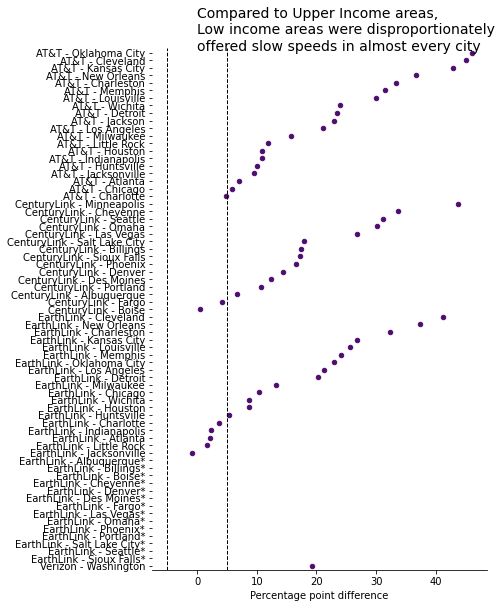

In [31]:
plot_observed(table, iv='income', fn=fn_observed_income,
              ylim=68.5,
              title = "Compared to Upper Income areas,\nLow income areas were disproportionately\noffered slow speeds in almost every city",)

<ipython-input-30-52d7faf4d682>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


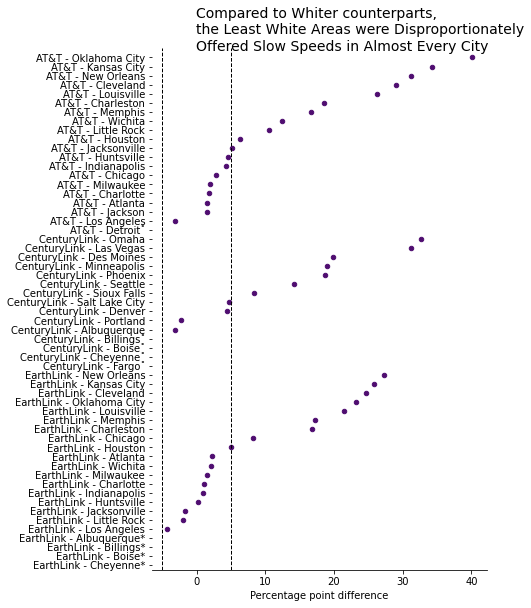

In [32]:
plot_observed(table, iv='race', fn=fn_observed_race, ylim=56.5,
              title = f"Compared to Whiter counterparts,\nthe Least White Areas were Disproportionately\nOffered Slow Speeds in Almost Every City")

<ipython-input-30-52d7faf4d682>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


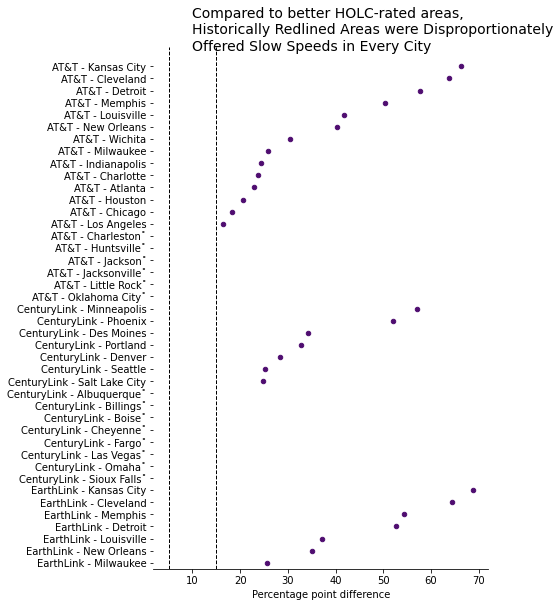

In [33]:
plot_observed(table, iv='redlining', fn=fn_observed_redlining, ylim=41.5,
              title = f"Compared to better HOLC-rated areas,\nHistorically Redlined Areas were Disproportionately\nOffered Slow Speeds in Every City",
)

## Regression

In [34]:
def preprocess_for_log_reg(df):
    df['n_providers'] = df['n_providers'] - 1
    df['income_dollars_below_median'] = df['income_dollars_below_median'] / 100

    df['constant'] = 1
    scaler = StandardScaler()
    df['lat_standard'] = scaler.fit_transform(df[['lat']])[:, 0]
    scaler = StandardScaler()
    df['lon_standard'] = scaler.fit_transform(df[['lon']])[:, 0]
    scaler = StandardScaler()
    df['ppl_per_sq_mile_standard'] = scaler.fit_transform(df[['ppl_per_sq_mile']])[:, 0]
    scaler = StandardScaler()
    df['income_dollars_below_median'] = scaler.fit_transform(df[['income_dollars_below_median']])[:, 0]
    
    # if there are no competitors, make this variable null.
    # Then this variable is linked to the outcome.
    df.loc[df.n_providers < 1, 'internet_perc_broadband'] = None
    
    scaler = StandardScaler()
    df['internet_perc_broadband'] = scaler.fit_transform(df[['internet_perc_broadband']])[:, 0]

    # this is our DV
    df['is_slow'] = df.apply(
        lambda x: 1 if x['speed_down_bins'] == "Slow (<25 Mbps)" else 0, 
        axis=1
    )
    
    for iv in ['income_level', 'race_quantile', 'redlining_grade']:
        df[iv] = df[iv].apply(lambda x: grade2rest.get(x, x))
    return df  

In [35]:
def train_and_return_coefs(formula, df, city, isp, model_name):
    """
    Workflow for fitting binary logistic regression for `formula`.
    This is formatted strangely because it'll be called by multiprocess(ing).Pool.
    """
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    import pandas as pd
    import numpy as np
    try:
        results = smf.logit(formula=formula, data=df).fit(disp=0)
        coefs = pd.DataFrame({
            'coef': results.params.values,
            'odds_ratio': np.exp(results.params.values),
            'pvalue': results.pvalues,
            'pr_sq': results.prsquared,
            'N' : len(df),
            'major_city': city,
            'state' : df.state.iloc[0],
            'isp': isp,
            'model' : model_name,
            'intercept': results.params['Intercept'],
        })
    except Exception as e:
        coefs = pd.DataFrame([{
            'N' : len(df),
            'major_city': city,
            'state' : df.state.iloc[0],
            'isp': isp,
            'model' : model_name,
            'error': e
        }])
    
    return coefs

In [36]:
def odds_to_probability(row, step=1):
    """
    See about this equation here:
    http://faculty.cas.usf.edu/mbrannick/regression/Logistic.html
    """
    a = row['intercept']
    b = row['coef']
    X = step
    try:
        return math.exp(a + b * X) / (1 + math.exp(a + b * X))
    except:
        return None

In [37]:
iv2treatment = {
    "income_level" : 'Upper Income',
    "race_quantile" : 'most white',
    "redlining_grade" : 'rest'
}

grade2rest = {
    'A' : 'rest',
    'B' : 'rest',
}

In [38]:
if not os.path.exists(fn_regression_all) or recalculate:
    data_regression = pd.DataFrame([])
    
    args = []
    for isp, fn in inputs.items():
        df = filter_df(fn, isp)
        df['major_city'] = df['major_city'].apply(lambda x: x.title())
        for (city, state), _df in df.groupby(by=['major_city', 'state']):
            _df = bucket_and_bin(_df)
            _df = preprocess_for_log_reg(_df)
            
            n_slow = len(_df[_df.speed_down_bins == 'Slow (<25 Mbps)'])
            n_not_slow = len(_df[_df.speed_down_bins != 'Slow (<25 Mbps)'])
            n_all = len(_df)
            if (_df.speed_down_bins.nunique() <= 1) or (n_slow / n_all <= .01) or (n_not_slow / n_all <= .01):
                # not enough speed
                continue
            for iv, treatment in iv2treatment.items():
                if iv == 'race_quantile':
                    n_minority_white = len(_df[_df.race_perc_non_white > .5])    
                    n_majority_white = len(_df[_df.race_perc_non_white < .5])            

                    # check only cities with at least 5 percent of addresses in minority white.
                    if n_minority_white / len(_df) <= .05 or n_majority_white / len(_df) <= .05:
                        print(f"skip {city} {isp} race")
                        continue
                elif iv == 'redlining_grade':
                    _df_rated = _df[~_df.redlining_grade.isnull()]
                    if len(_df_rated) <= len(_df) * .05:
                        print(f"skip {city} {isp} redline")
                        continue
                    if 'D' not in _df['redlining_grade'].unique().tolist():
                        print(f"skip {city} {isp} redline")
                        continue

                formula = f"is_slow ~ C({iv}, Treatment('{treatment}'))"
                args.append([formula, _df, city, isp, f"{iv}_alone"])
                if city in ['Omaha', 'Phoenix'] and iv == 'redlining_grade':
                    formula += " + ppl_per_sq_mile_standard + internet_perc_broadband"
                else:
                    formula += " + ppl_per_sq_mile_standard + n_providers + internet_perc_broadband"
                args.append([formula, _df, city, isp, f"{iv}_controls"])

                # ablation formulas
                if city in ['Omaha', 'Phoenix'] and iv == 'redlining_grade':
                    formulas = [" + ppl_per_sq_mile_standard", " + internet_perc_broadband"]
                else:
                    formulas = [" + ppl_per_sq_mile_standard", " + n_providers ",  " + internet_perc_broadband"]
                for iv_ in formulas:
                    formula = f"is_slow ~ C({iv}, Treatment('{treatment}'))"
                    formula += "".join([f for f in formulas if f != iv_])
                    model_name =  f"{iv}_minus{iv_.replace(' + ', '_')}"
                    args.append([formula, _df, city, isp, model_name])

    with multiprocess.get_context("spawn").Pool(n_jobs) as pool:
        for coefs in tqdm(pool.istarmap(train_and_return_coefs, args), 
                           total=len(args)):
            data_regression = data_regression.append(coefs)

    # treatment group IE upper income, most white, best graded
    data_regression['probability_treatment'] = data_regression.apply(odds_to_probability, step=0, axis=1)
    # exposure group IE lower income, least white, redlined
    data_regression['probability_exposure'] = data_regression.apply(odds_to_probability, step=1, axis=1)
    data_regression['odds_directional'] = data_regression.apply(lambda x: x['odds_ratio'] * -1 if x['coef'] <0 else  x['odds_ratio'], axis=1)
    data_regression['is_coef_positive'] = data_regression.coef > 0
    # positive if exposure group has higher liklihood of slower speeds than treatment group
    data_regression['probability_delta'] = data_regression['probability_exposure'] - data_regression['probability_treatment']
    data_regression['perc_probability'] =  data_regression['probability_exposure'] / data_regression['probability_treatment']
    data_regression = data_regression[data_regression.index != 'Intercept']

    data_regression.to_csv(fn_regression_all)
    controls = data_regression[data_regression.model.str.contains('_controls')]
    controls.loc["C(income_level, Treatment('Upper Income'))[T.Low]"].to_csv(fn_regression_income)
    controls.loc["C(race_quantile, Treatment('most white'))[T.least white]"].to_csv(fn_regression_race)
    controls.loc["C(redlining_grade, Treatment('rest'))[T.D]"].to_csv(fn_regression_redlining)
    
else:
    data_regression = pd.read_csv(fn_regression_all, index_col=0)

In [39]:
len(set(data_regression[~data_regression.coef.isnull()].major_city.unique()))

40

## Ablation

In [40]:
# mean psuedo r-squared (goodness of fit) for each model across cities and ISPs.
for model, _df in data_regression.groupby(['model']):
    mean_pr = _df.groupby(['major_city', 'state', 'isp']).first().pr_sq.mean()
    print(model, mean_pr)

income_level_alone 0.0421494957308795
income_level_controls 0.08262173045110965
income_level_minus_internet_perc_broadband 0.0759137242746971
income_level_minus_n_providers  0.07063354836745209
income_level_minus_ppl_per_sq_mile_standard 0.06633096770366104
race_quantile_alone 0.02527529336819734
race_quantile_controls 0.08188691537520522
race_quantile_minus_internet_perc_broadband 0.06394249650923328
race_quantile_minus_n_providers  0.07032190348173313
race_quantile_minus_ppl_per_sq_mile_standard 0.06182688258331634
redlining_grade_alone 0.06403845085385912
redlining_grade_controls 0.13360545645366942
redlining_grade_minus_internet_perc_broadband 0.11885953708671705
redlining_grade_minus_n_providers  0.1105816918953646
redlining_grade_minus_ppl_per_sq_mile_standard 0.10698335731917312


The ablated IV that results in the least change from the observed are the most influential.

In [41]:
income_ablation = data_regression[
    (data_regression['model'].str.contains('income_level_minus_')) &
    (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
].merge(table, on=['isp', 'major_city', 'state'])
income_ablation['delta'] = abs(income_ablation['probability_delta'] - income_ablation['prop_slow_income_delta'])
income_ablation.sort_values(by='delta', ascending=True).groupby('major_city').first().model.value_counts(normalize=True)

income_level_minus_internet_perc_broadband     0.50
income_level_minus_n_providers                 0.35
income_level_minus_ppl_per_sq_mile_standard    0.15
Name: model, dtype: float64

In [42]:
race_ablation = data_regression[
    (data_regression['model'].str.contains('race_quantile_minus_')) &
    (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
].merge(table, on=['isp', 'major_city', 'state'])
race_ablation['delta'] = abs(race_ablation['probability_delta'] - race_ablation['prop_slow_race_delta'])
race_ablation.sort_values(by='delta', ascending=True).groupby('major_city').first().model.value_counts(normalize=True)

race_quantile_minus_internet_perc_broadband     0.529412
race_quantile_minus_n_providers                 0.235294
race_quantile_minus_ppl_per_sq_mile_standard    0.235294
Name: model, dtype: float64

In [43]:
redlining_ablation = data_regression[
    (data_regression['model'].str.contains('redlining_grade_minus_')) &
    (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
].merge(table, on=['isp', 'major_city', 'state'])
redlining_ablation['delta'] = abs(redlining_ablation['probability_delta'] - redlining_ablation['prop_slow_redlining_delta'])
redlining_ablation.sort_values(by='delta', ascending=False).groupby('major_city').first().model.value_counts(normalize=True)

redlining_grade_minus_ppl_per_sq_mile_standard    0.666667
redlining_grade_minus_internet_perc_broadband     0.259259
redlining_grade_minus_n_providers                 0.074074
Name: model, dtype: float64

## Where to disparities persist?

In [44]:
data_regression[
        (data_regression.model == f'redlining_grade_controls') &
        (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
    ].sort_values('coef', ascending=False).major_city.unique()

array(['Cleveland', 'Omaha', 'Newark', 'Minneapolis', 'Phoenix',
       'Detroit', 'Kansas City', 'Wichita', 'Louisville', 'Philadelphia',
       'Milwaukee', 'Atlanta', 'Little Rock', 'Houston', 'Denver',
       'New Orleans', 'Memphis', 'Portland', 'Des Moines', 'Indianapolis',
       'Charlotte', 'Seattle', 'Chicago', 'Salt Lake City', 'Los Angeles',
       'Jackson', 'Boston'], dtype=object)

In [45]:
income = (
    data_regression[
        (data_regression.model == f'income_level_controls') &
        (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
    ].sort_values('coef', ascending=False)
    .merge(
        data_regression[
            (data_regression.model == f'income_level_alone') &
            (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
        ], how='left', on=['major_city', 'state', 'isp'],
        suffixes=['', '_alone']
    )
).drop_duplicates(subset=['isp', 'major_city', 'state'])
income = income[income.major_city.isin(income_cities)]

race = (
    data_regression[
        (data_regression.model == f'race_quantile_controls') &
        (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
    ].sort_values(['coef', 'state'], ascending=False)
    .merge(
        data_regression[
            (data_regression.model == f'race_quantile_alone') &
            (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
        ], how='left', on=['major_city', 'state', 'isp'],
        suffixes=['', '_alone']
    )
).drop_duplicates(subset=['isp', 'major_city', 'state'])
race = race[race.major_city.isin(race_cities)]

redlining = (
    data_regression[
        (data_regression.model == f'redlining_grade_controls') &
        (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
    ].sort_values('coef', ascending=False)
    .merge(
        data_regression[
            (data_regression.model == f'redlining_grade_alone') &
            (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
        ], how='left', on=['major_city', 'state', 'isp'],
        suffixes=['', '_alone']
    )
).drop_duplicates(subset=['isp', 'major_city', 'state'])
redlining = redlining[redlining.major_city.isin(redlining_cities)]

In [46]:
threshold = 1
sig_income = income[income.pvalue < threshold]
slowest_income = sig_income[sig_income.probability_delta > 0.05]

sig_race = race[race.pvalue < threshold]
slowest_race = sig_race[sig_race.probability_delta > 0.05]

sig_redlining = redlining[redlining.pvalue < threshold]
slowest_redlining = sig_redlining[sig_redlining.probability_delta > 0.05]

print(f"Income ({len(sig_income)} city-ISP pairs)"
     f"\n- low income areas recieve greater proprotion of slow speeds in {len(slowest_income)} city-ISP pairs, or {len(slowest_income) / len(sig_income) * 100:.1f}% of cases.\n"
     f"- same pattern in {slowest_income.major_city.nunique()} out of {sig_income.major_city.nunique()} cities ({slowest_income.major_city.nunique() / sig_income.major_city.nunique():.2f}%)")
print(f"Race and Ethnicity ({len(sig_race)} city-ISP pairs)"
     f"\n- least white areas recieve greater proportion of slow speeds in {len(slowest_race)} city-ISP pairs, or {len(slowest_race) / len(sig_race) * 100:.1f}% of cases.\n"
     f"- same pattern in {slowest_race.major_city.nunique()} out of {sig_race.major_city.nunique()} cities ({slowest_race.major_city.nunique() / sig_race.major_city.nunique():.2f}%)")

print(f"Redlining ({len(sig_redlining)} city-ISP pairs)"
     f"\n- hazardous areas recieve greater proprotion of slow speeds in {len(slowest_redlining)} city-ISP pairs, or {len(slowest_redlining) / len(sig_redlining) * 100:.1f}% of cases.\n"
     f"- same pattern in {slowest_redlining.major_city.nunique()} out of {sig_redlining.major_city.nunique()} cities ({slowest_redlining.major_city.nunique() / sig_redlining.major_city.nunique():.2f}%)")


Income (58 city-ISP pairs)
- low income areas recieve greater proprotion of slow speeds in 42 city-ISP pairs, or 72.4% of cases.
- same pattern in 27 out of 38 cities (0.71%)
Race and Ethnicity (51 city-ISP pairs)
- least white areas recieve greater proportion of slow speeds in 16 city-ISP pairs, or 31.4% of cases.
- same pattern in 11 out of 32 cities (0.34%)
Redlining (36 city-ISP pairs)
- hazardous areas recieve greater proprotion of slow speeds in 23 city-ISP pairs, or 63.9% of cases.
- same pattern in 14 out of 22 cities (0.64%)


In [47]:
set(all_cities) - set(income[income.probability_delta > 0].major_city)

TypeError: 'int' object is not iterable

In [ ]:
trend = set(sig_income.major_city.unique().tolist() + sig_race.major_city.unique().tolist() + sig_redlining.major_city.unique().tolist())
all_cities = set(income.major_city.unique().tolist() + race.major_city.unique().tolist() + redlining.major_city.unique().tolist())
cities = set(data_regression.major_city.unique())
len(all_cities)
all_cities - trend

In [ ]:
len(income[income.pvalue < .05]) / len(income)

In [ ]:
income.pr_sq.describe()

In [ ]:
income.odds_ratio.apply(lambda x: x>1.5).value_counts(normalize=True)

In [ ]:
len(race[race.pvalue < .05]) / len(race)

In [ ]:
race.pr_sq.describe()

In [ ]:
race.odds_ratio.apply(lambda x: x>1.5).value_counts(normalize=True)

In [ ]:
len(redlining[redlining.pvalue < .05]) / len(redlining)

In [ ]:
redlining.pr_sq.describe()

In [ ]:
redlining.odds_ratio.apply(lambda x: x>1.5).value_counts(normalize=True)

See the factor that lead to the greatest adjustments for any city

In [ ]:
income_ablation_ = data_regression[
    (data_regression['major_city'] == 'Seattle') &
    (data_regression['model'].str.contains('income_level_minus_')) & 
    (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
].merge(table, on=['isp', 'major_city', 'state'])
income_ablation_['delta'] = abs(income_ablation_['probability_delta'] - 
                                income_ablation_['prop_slow_income_delta'])
income_ablation_.sort_values(by='delta', ascending=True)

In [ ]:
race_ablation_ = data_regression[
    (data_regression['major_city'] == 'Charleston') &
    (data_regression['model'].str.contains('race_quantile_minus_')) &
    (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
].merge(table, on=['isp', 'major_city', 'state'])
race_ablation_['delta'] = abs(race_ablation_['probability_delta'] - 
                              race_ablation_['prop_slow_income_delta'])
race_ablation_.sort_values(by='delta', ascending=True)

In [ ]:
redlining_ablation_ = data_regression[
    (data_regression['major_city'] == 'Minneapolis') &
    (data_regression['model'].str.contains('redlining_grade_minus_')) &
    (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
].merge(table, on=['isp', 'major_city', 'state'])
redlining_ablation_['delta'] = abs(redlining_ablation_['probability_delta'] - 
                                  redlining_ablation_['prop_slow_income_delta'])
redlining_ablation_.sort_values(by='delta', ascending=True)

## Plots with Adjustments

In [ ]:
label2marker = {
    'Observed': 'o',
    'Adjusted': '^'
}

In [ ]:
def plot_adjusted(to_plot, ylim=33.5, figsize=(6, 8), fn=fn_adjusted_redlining,
                  title= f"After adjusting for other factors, Redlined areas\nstill disprportionately offered slow Internet speeds",
                  title_y = -3.2, title_x= -.05):
    legend_elements = [Line2D([0], [0], marker=label2marker.get(label), color='w', 
                          label=label, markerfacecolor=c, markersize=10)
                   for label, c in {'Observed': color_1, 'Adjusted': color_2}.items()][::-1] 
    
    to_plot_ = to_plot#[(to_plot['pvalue'] < 0.05)]
    to_plot_['major_city_isp'] = to_plot_.apply(lambda x: x['isp'] + ' - ' + x['major_city'], axis=1)

    to_plot_['Observed'] = to_plot_.probability_delta_alone * 100
    to_plot_['Adjusted'] = to_plot_.probability_delta * 100

    to_plot_ = to_plot_.sort_values(by=['Adjusted', 'state', 'Observed'], ascending=False)

    ax = to_plot_.plot(y='major_city_isp', x='Observed', 
                      color=color_1,
                      kind='scatter', figsize=figsize)
    to_plot_.plot(y='major_city_isp', x='Adjusted', 
                 color=color_2, ax=ax, marker='^',
                 alpha = [bool2alpha.get(_) for _ in to_plot_.pvalue < 0.05],
                 kind='scatter')

    x1 = to_plot_['Adjusted'].tolist()
    x2 = to_plot_['Observed'].tolist()
    n = to_plot_['major_city_isp'].tolist()
    for i in range(0, len(x1)):
        ax.plot([x1[i], x2[i]], [n[i], n[i]], '-', 
                color='black', zorder=-1, alpha=.8)

    to_plot_['isp'] = pd.Categorical(to_plot_['isp'], ["AT&T", "Verizon", "CenturyLink", "EarthLink"])
    to_plot_ = to_plot_.sort_values(by=['isp','Adjusted', 'state', 'Observed'], 
                                    ascending=[True, False, False, False])
    to_plot_[['major_city', 'isp', 'Adjusted', 'Observed', 'state']].to_csv(fn, index=False)    

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.gca().invert_yaxis()

    ax.set_ylabel("")
    labels = ax.get_xticks().tolist()
    labels = [int(_) for _ in labels]
    # labels[0] = "0%"
    ax.set_xticklabels(labels)
    ax.set_xlabel("Percentage point difference")
    # ax.get_legend().remove()

    plt.axvline(x=0,linewidth=1, color='black', linestyle='--', ymax=.96)

    plt.text(title_x, title_y, 
             title,
             size=14,
             horizontalalignment='left',
             verticalalignment='center',);
    ax.set_ylim(bottom=ylim)

    ax.legend(handles=legend_elements[::-1],
                  loc='lower left', 
                  bbox_to_anchor= (-0.025, .97), 
                  ncol=5,
                  handletextpad=0.0,
                  labelspacing=0, 
                  borderaxespad=.1, 
                  borderpad=0.1,
                  frameon=False,
                  prop={'size': 9.2})

In [ ]:
to_plot = income
plot_adjusted(to_plot, ylim=58.5, figsize=(6, 10), 
              fn=fn_adjusted_income,
              title_y = -4.2, title_x = -14, 
              title= f"After adjusting for other factors, low income areas\nstill disporportionately offered slow Internet speeds",
)

In [ ]:
to_plot = race
plot_adjusted(to_plot, ylim=52.5, figsize=(6, 10), 
              fn=fn_adjusted_race,
              title_y = -3.5, title_x = -15,
              title= f"After adjusting for other factors, least white areas\nstill disproportionately offered slow Internet speeds",
)

In [ ]:
to_plot = redlining
plot_adjusted(to_plot, title_y=-3.2, title_x=-6, ylim=37.5, fn=fn_adjusted_redlining)